# To-do: 
- Based on the above, we need to remove the names of the co-hosts from the list of words that show up!
- string cleaning

# Adjust stop words

In [1]:
from sklearn.feature_extraction import text 

text.ENGLISH_STOP_WORDS

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [2]:
add_stop_words = ['anderson', 'cooper', 'rachel', 'maddow', 'cnn', 'msnbc']

In [3]:
full_stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [4]:
full_stop_words

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'anderson',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside

## Load in Data

### Read in the total list of data files

In [5]:
#import libraries
import glob 
import os
import matplotlib.pyplot as plt

#step 1: get a list of file names to read into the dataset
repo_path = os.path.dirname(os.getcwd()) #get the correct file path 
rm_paths = glob.glob(repo_path + "/data/01-raw/rachel_maddow/*.txt") #the paths for the rachel maddow transcript files
ac_paths = glob.glob(repo_path + "/data/01-raw/anderson_cooper/*.txt") #the paths for the anderson cooper transcript files

all_liberal_files = rm_paths + ac_paths


### Read in text of transcript files

In [6]:
raw_text = [] #create a container to hold the datafiles 

#step 2: read in each transcript as its own string and append to the list of raw documents
for transcript in all_liberal_files:
    text = open(transcript, encoding='utf-8').read()
    raw_text.append(text)


In [7]:
print("Our liberal news corpus consists of {:,} total transcripts, sourced from Anderson Cooper 360 and the Rachel Maddow Show.".format(len(raw_text)))

Our liberal news corpus consists of 1,008 total transcripts, sourced from Anderson Cooper 360 and the Rachel Maddow Show.


## Data Pre-Processing

### Spacy Implementation & Removal of Stop Words 
This analysis is useful if we want more control over the corpus of stop words that are used in our analysis

In [8]:
#Compare spacy implemtation to the sklearn #loads spacy and turns off some aspects 
# import spacy
# nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])


## Word- Frequency Analysis

### Use CountVectorizer to get the unique vocabulary list and eliminate stop words



In [9]:
#import the required package for the tfidf vector
from sklearn.feature_extraction.text import CountVectorizer

#step 1: set up the tfidf vectorizer
vectorizer = CountVectorizer(min_df = 50, 
                             stop_words = full_stop_words, 
                             max_df = 0.8) #update/justify using these settings 
 
#step 2: apply the vectorizer to the corpus of documents (& store in document matrix X )
X = vectorizer.fit(raw_text) #should we use just .fit or .fit_transform? The latter actually results in the creation of a matrix object (where # of cols = # of words in the vocab)

#step 3: print out the vocabulary found by the tfid object
print("There are {:,} unique words in the vocabulary.".format(len(X.vocabulary_)))

There are 4,986 unique words in the vocabulary.


In [10]:
#check to see if "covid" is in the dictionary
vocab = X.vocabulary_

#vocab['covid'] #results in an index of 1197) 
#Note: this is NOT equivalent to the number of times covid appears in the documents
# the number below is solely an index value

In [11]:
#check to see if "coronavirus" is in the dictionary - return index

vocab['coronavirus']

1095

### Get a Word-Frequency Table from CountVectorizer
   Note: need to double-check how the counts are arrived at - is it by document or number of occurences in a given document?

In [12]:
X_transformed = vectorizer.fit_transform(raw_text)


In [13]:
array_of_words = vectorizer.get_feature_names_out()
array_of_words

array(['00', '01', '02', ..., 'zero', 'zone', 'zoom'], dtype=object)

In [14]:
array_of_counts = X_transformed.toarray().sum(axis=0) #sum the number of occurences of a word across the entire liberal corpus
array_of_counts

array([3500,  413,  396, ...,  483,  190,   81], dtype=int64)

In [15]:
word_frequency_dictionary = dict(zip(array_of_words,array_of_counts))

### Plot the Top 10 Most Frequency Occuring Words

In [16]:
from operator import itemgetter

#set the number of top words to see
num_top_words = 10

top_10_words = dict(sorted(word_frequency_dictionary.items(), key = itemgetter(1), reverse = True)[:num_top_words])

print(top_10_words)


{'republicans': 6014, 'dr': 5812, 'police': 5547, 'health': 5397, 'court': 5303, 'vote': 5294, 'justice': 5266, 'vaccine': 5111, 'department': 5027, 'voice': 5019}


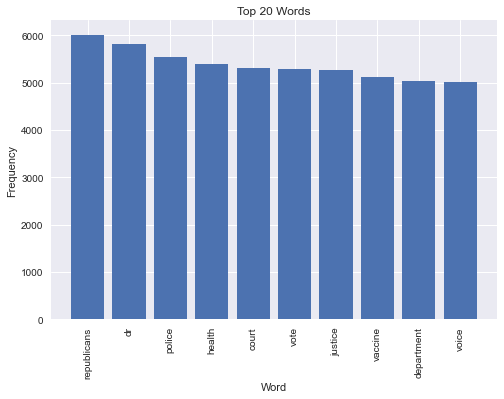

In [17]:
plt.style.use('seaborn')  

x = top_10_words.keys()
y = top_10_words.values()
plt.bar(x,y)
plt.xlabel('Word')
plt.xticks(rotation='vertical')
plt.ylabel('Frequency')
plt.title('Top 20 Words')

plt.show()

In [18]:
# total_unique_words = X.vocabulary_ #, key=lambda d: d[1]) 

# total_unique_words
#X.vocabulary_

## Co-Occurence Analysis

- Need to do string cleaning. 
- For now, appearance anywhere in a transcript increases count by 1.
- it might make sense to do this with the count vectorizer from above?

In [19]:
# import packages
from collections import Counter
import spacy
import numpy as np

In [20]:
# instantiate nlp
nlp = spacy.load('en_core_web_sm', disable = ['parser'])

In [21]:
# need to do some pre-processing/string cleaning*****
# warning: takes a while
liberal_nlp = [nlp(text) for text in raw_text]

In [22]:
# num transcripts
num_transcripts = len(liberal_nlp)

In [23]:
# see full lemma set - identify how covid is named
lemma_set = set(token.lemma_.lower() for transcript in liberal_nlp for token in transcript)
len(lemma_set)

56824

In [24]:
# covid_terms
covid_terms = ['coronavirus', 'covid', 'covid-19']

lemma_set.intersection(set(covid_terms))

{'coronavirus', 'covid', 'covid-19'}

In [25]:
# counters
lemma_counts = Counter()
co_occur_counts = Counter()
covid_count = 0

# for each transcript, add unique lemmas to counter
# increase co-occurrence and covid counter if covid terms overlap lemma set
for transcript in liberal_nlp:
    lemmas = {token.lemma_.lower() for token in transcript}
    lemma_counts.update(lemmas)
    if not lemmas.isdisjoint(set(covid_terms)):
        co_occur_counts.update(lemmas)
        covid_count += 1

# P(covid)
covid_ratio = covid_count / num_transcripts # constant

# calculate PMI only for words that co-occur (do not care about others)
pmi = list()
for lemma, count in co_occur_counts.items():
    
    lemma_ratio = lemma_counts[lemma] / num_transcripts # P(lemma)
    co_ratio = co_occur_counts[lemma] / num_transcripts # P(covid, lemma)
    
    pmi += [(lemma, 
             np.log2(co_ratio / (covid_ratio * lemma_ratio)))]

# sort list of tuples by pmi, descending
pmi_sort = sorted(pmi, key = lambda x: x[1], reverse = True)

In [26]:
# see top 100 pmi values (note ties)
pmi_sort[0:100]

[('ppe', 0.21240833276382595),
 ('240,000', 0.21240833276382595),
 ('retailer', 0.21240833276382595),
 ('intubate', 0.21240833276382595),
 ('visualization', 0.21240833276382595),
 ('coronavirus', 0.21240833276382595),
 ('birx', 0.21240833276382595),
 ('gown', 0.21240833276382595),
 ('javits', 0.21240833276382595),
 ('alleviate', 0.21240833276382595),
 ('2,200', 0.21240833276382595),
 ('inequity', 0.21240833276382595),
 ('gambit', 0.21240833276382595),
 ('ebola', 0.21240833276382595),
 ('skyrocket', 0.21240833276382595),
 ('caseload', 0.21240833276382595),
 ('steeply', 0.21240833276382595),
 ('nationalize', 0.21240833276382595),
 ('inslee', 0.21240833276382595),
 ('patchwork', 0.21240833276382595),
 ('reeves', 0.21240833276382595),
 ('n95', 0.21240833276382595),
 ('destiny', 0.21240833276382595),
 ('garcetti', 0.21240833276382595),
 ('merkel', 0.21240833276382595),
 ('lizard', 0.21240833276382595),
 ('metaphor', 0.21240833276382595),
 ('tolerance', 0.21240833276382595),
 ('tampa', 0.212

## Topic Modeling
* need to do string cleaning, remove host names, etc.
* maybe remove all named entities?

In [27]:
num_topics = 10

import numpy as np
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = num_topics, 
                                random_state = 0)

lda.fit(X_transformed)

LatentDirichletAllocation(random_state=0)

In [28]:
# shape
lda.components_.shape

(10, 4986)

In [29]:
# normalize to get probability distributions
topic_word_dist = np.array([row / row.sum() for row in lda.components_])

topic_word_dist.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [30]:
# list top 20 words in each topic
for topic_idx in range(num_topics):
    print('\n', 'Topic ', topic_idx, ':', sep = '')
    sort_idx = np.argsort(-topic_word_dist[topic_idx])
    for rank in range(20):
        word_idx = sort_idx[rank]
        print('{:<80} {:<10}'.format(array_of_words[word_idx], topic_word_dist[topic_idx, word_idx]))


Topic 0:
capitol                                                                          0.011607527959047483
january                                                                          0.011463377142405801
committee                                                                        0.007116165826569447
republicans                                                                      0.006398215079524874
party                                                                            0.006193101811289404
6th                                                                              0.006023413323713187
senate                                                                           0.005477447524148204
attack                                                                           0.004899273771877488
pence                                                                            0.004656221794257016
congress                                                                

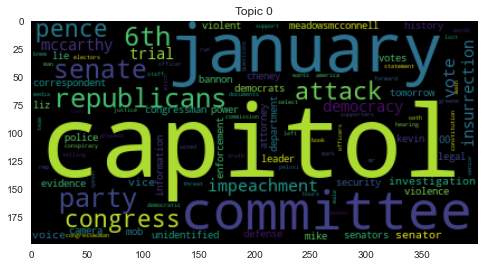

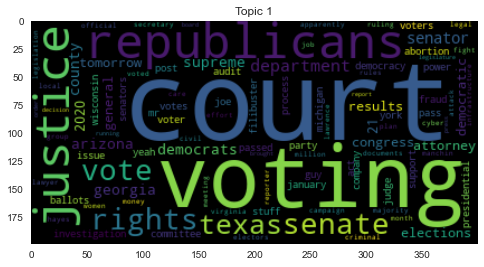

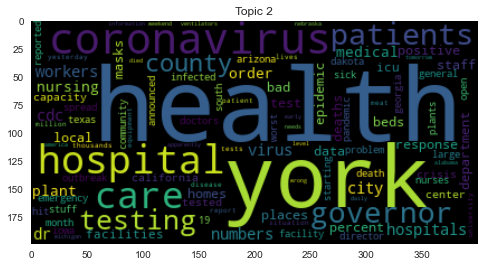

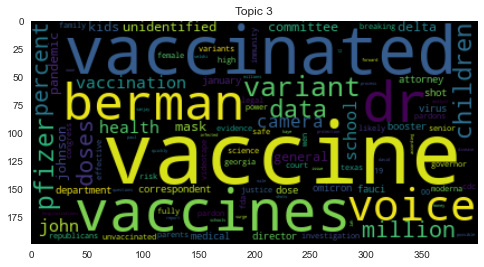

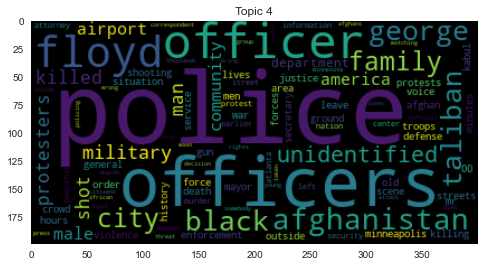

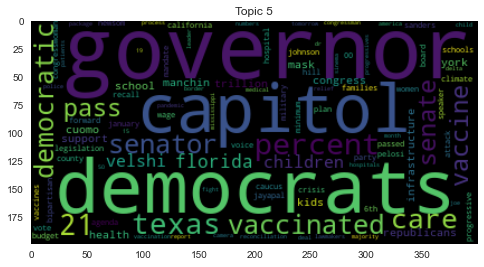

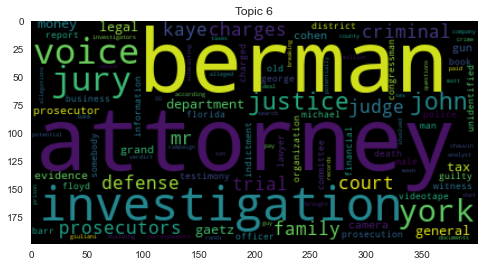

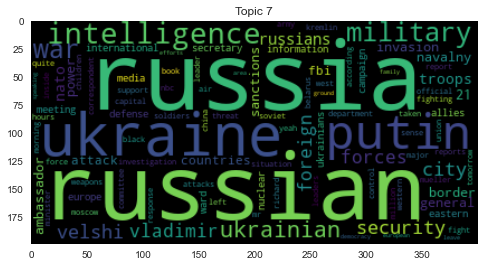

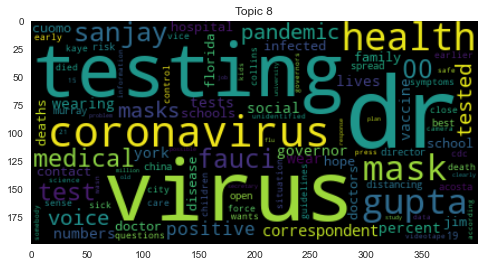

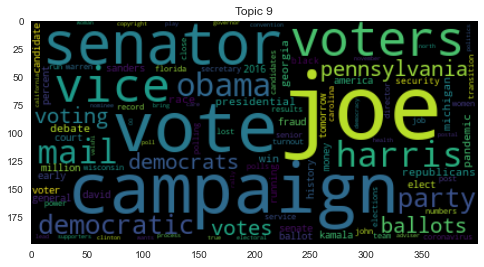

In [31]:
from wordcloud import WordCloud

for topic_idx in range(num_topics):
    wc = WordCloud(max_words = 100)
    wc.generate_from_frequencies(dict(zip(array_of_words, topic_word_dist[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title('Topic %d' % topic_idx)
    plt.grid(visible = None)

## Sentiment Analysis